In [20]:
import numpy as np
import matplotlib.pyplot as plt

from jax import jit, vmap, config
import jax.numpy as jnp
import jax.random as jr
import jax.scipy.linalg as jsl

import numpyro
import numpyro.distributions as dist
from numpyro.infer.initialization import init_to_value

from emcee.autocorr import integrated_time
import pandas as pd
from chainconsumer import ChainConsumer, Chain, Truth

from PTA import PTA
from likelihood import Likelihood, get_likelihood_obj
from samples import Samples

# use double precision
config.update('jax_enable_x64', True)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# make PTA and likelihood objects
pta = PTA(Np=1,
          Tspan_yr=15.,
          Nf=5,
          model_wn=True,
          model_rn=True,
          model_gwb=False,
          model_cw=False,
          seed=47)
l = get_likelihood_obj(pta)

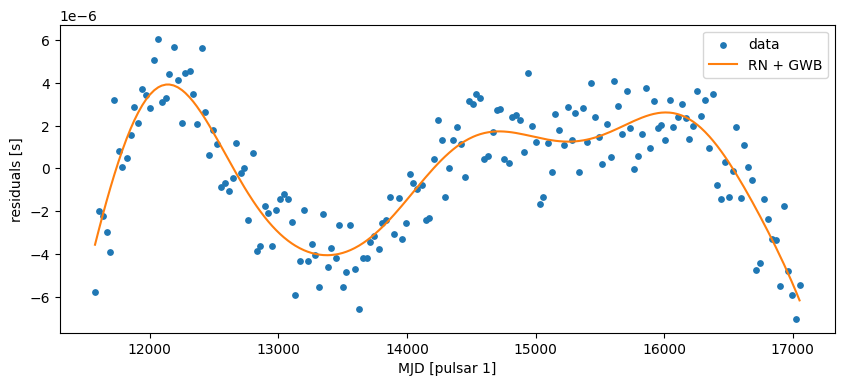

In [3]:
# plot data and injected signals
psr_ndx = 0
plt.figure(figsize=(10, 4))
plt.scatter(pta.MJDs[psr_ndx], pta.residuals[psr_ndx], color='C0', s=15, label='data')
if pta.model_gwb or pta.model_rn:
    rn_gwb_residuals_inj = pta.Rs[psr_ndx] @ pta.Fs[psr_ndx] @ pta.a_inj.reshape((pta.Np, pta.Na))[psr_ndx]
    plt.plot(pta.MJDs[psr_ndx], rn_gwb_residuals_inj, color='C1', label='RN + GWB')
if pta.model_cw:
    cw_residuals_inj = pta.Rs[psr_ndx] @ pta.Fs[psr_ndx] @ pta.get_CW_coefficients(pta.x_inj[pta.cw_psr_ndxs])[psr_ndx]
    plt.plot(pta.MJDs[psr_ndx], cw_residuals_inj, color='C2', label='CW')
if (pta.model_gwb or pta.model_rn) and pta.model_cw:
    plt.plot(pta.MJDs[psr_ndx], rn_gwb_residuals_inj + cw_residuals_inj, color='C4', label='RN + GWB + CW')
plt.xlabel(f'MJD [pulsar {psr_ndx + 1}]')
plt.ylabel('residuals [s]')
plt.legend()
plt.show()

In [4]:
# posterior density
@jit
def lnpost(x):

    # unpack parameters
    efacs = x[pta.efac_ndxs]
    rn_hypers = x[pta.rn_ndxs]
    # gwb_hypers = x[pta.gwb_ndxs]
    # cw_psr_params = x[pta.cw_psr_ndxs]
    # psr_dists = x[pta.psr_dist_ndxs]
    a = x[pta.a_ndxs]

    # prior
    lnprior_val = l.uniform_lnprior(x)
    lnprior_val += l.a_lnprior_rn(rn_hypers, a)
    # lnprior_val += l.psr_dist_lnprior(psr_dists)

    # likelihood
    # a_cw = pta.get_CW_coefficients(cw_psr_params).flatten()
    lnlike_val = l.lnlike(efacs, a)

    return lnprior_val + lnlike_val


vectorized_lnpost = jit(vmap(lnpost))

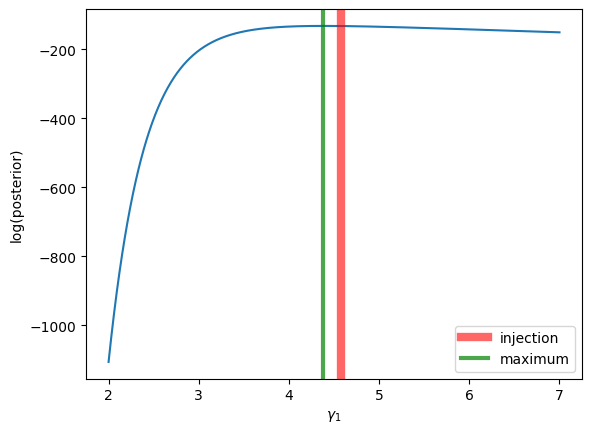

In [5]:
# plot cross-section of posterior
param_ndx = 2
num_evals = 1000
param_vals = jnp.linspace(pta.x_mins[param_ndx], pta.x_maxs[param_ndx], num_evals)
params = jnp.tile(pta.x_inj, (num_evals, 1))
params = params.at[:, param_ndx].set(param_vals)
lnposts = vectorized_lnpost(params)
plt.plot(param_vals, lnposts)
plt.axvline(pta.x_inj[param_ndx], color='red', label='injection', lw=6, alpha=0.6)
plt.axvline(param_vals[jnp.argmax(lnposts)], color='green', label='maximum', lw=3, alpha=0.7)
plt.legend()
plt.xlabel(pta.x_labels[param_ndx])
plt.ylabel('log(posterior)')
plt.show()

In [6]:
# @jit
# def transform_a(rn_hypers, gwb_hypers, a_standard):
#     rn_phi = jnp.zeros((pta.Na, pta.Np, pta.Np))
#     rn_phi = rn_phi.at[:, jnp.arange(pta.Np), jnp.arange(pta.Np)].set(pta.vectorized_get_rho_diag(rn_hypers.reshape((pta.Np, 2))).T)
#     gwb_phi = pta.get_rho_diag(gwb_hypers)[:, None, None] * pta.alpha[None, :, :]
#     phi = rn_phi + gwb_phi
#     # phi = rn_phi + gwb_phi + jnp.ones((pta.Na))[:, None, None] * jnp.eye(pta.Np, pta.Np)[None, :, :] * 1.e-6
#     Lc = vmap(lambda x: jsl.cholesky(x, lower=True))(phi)
#     a_transformed = vmap(lambda L, x: L @ x)(Lc, a_standard.reshape((pta.Np, pta.Na)).T).T.flatten()
#     return a_transformed

@jit
def transform_a(rn_hypers, a_standard):
    phi = jnp.zeros((pta.Na, pta.Np, pta.Np))
    phi = phi.at[:, jnp.arange(pta.Np), jnp.arange(pta.Np)].set(pta.vectorized_get_rho_diag(rn_hypers.reshape((pta.Np, 2))).T)
    Lc = vmap(lambda x: jsl.cholesky(x, lower=True))(phi)
    a_transformed = vmap(lambda L, x: L @ x)(Lc, a_standard.reshape((pta.Np, pta.Na)).T).T.flatten()
    return a_transformed

In [7]:
# def sampling_model():
#     # uniform prior on hyper-parameters
#     efacs = numpyro.sample('efacs', dist.Uniform(pta.efac_mins, pta.efac_maxs))
#     rn_hypers = numpyro.sample('rn_hypers', dist.Uniform(pta.rn_mins, pta.rn_maxs))
#     gwb_hypers = numpyro.sample('gwb_hypers', dist.Uniform(pta.gwb_mins, pta.gwb_maxs))

#     # uniform prior on CW parameters and pulsar phases
#     cw_params = numpyro.sample('cw', dist.Uniform(pta.cw_mins, pta.cw_maxs))
#     psr_phases = numpyro.sample('psr_phases', dist.Uniform(pta.psr_phase_mins, pta.psr_phase_maxs))

#     # normal prior on pulsar distances
#     psr_dists = numpyro.sample('psr_dists', dist.Normal(pta.psr_dists_inj, pta.psr_dists_stdev))

#     # normal prior on Fourier coefficients
#     a_standard = numpyro.sample('a_standard', dist.Normal().expand([pta.Na_PTA]))
#     a_transformed = transform_a(rn_hypers, gwb_hypers, a_standard)
#     a = numpyro.deterministic('a', a_transformed)

#     # get CW coefficients
#     a_cw = pta.get_CW_coefficients(jnp.concatenate((cw_params, psr_phases, psr_dists))).flatten()

#     # likelihood
#     numpyro.factor('ln_likelihood', l.lnlike(efacs, a + a_cw))

In [8]:
def sampling_model():
    # uniform prior on hyper-parameters
    efacs = numpyro.sample('efacs', dist.Uniform(pta.efac_mins, pta.efac_maxs))
    rn_hypers = numpyro.sample('rn_hypers', dist.Uniform(pta.rn_mins, pta.rn_maxs))

    # normal prior on Fourier coefficients
    a_standard = numpyro.sample('a_standard', dist.Normal().expand([pta.Na_PTA]))
    a_transformed = transform_a(rn_hypers, a_standard)
    a = numpyro.deterministic('a', a_transformed)
    # scale = jnp.sqrt(pta.get_rho_diag(rn_hypers).flatten())
    # a = numpyro.sample('a', dist.Normal(loc=jnp.zeros((pta.Na)),
    #                                     scale=scale))

    # likelihood
    numpyro.factor('ln_likelihood', l.lnlike(efacs, a))

In [9]:
# injected parameters in dictionary amenable to sampler
# x_inj_dict = {'efacs':pta.efacs_inj, 'rn_hypers':pta.rn_inj, 'gwb_hypers':pta.gwb_inj,
#               'cw':pta.cw_inj, 'psr_phases':pta.psr_phases_inj, 'psr_dists':pta.psr_dists_inj,
#               'a_standard':jnp.zeros(pta.Na_PTA)}
x_inj_dict = {'efacs':pta.efacs_inj, 'rn_hypers':pta.rn_inj, 'a':pta.a_inj}

In [ ]:
# nuts_kernel = numpyro.infer.NUTS(sampling_model, dense_mass=[('rn_hypers',), ('gwb_hypers',), ('cw',)])
# nuts_kernel = numpyro.infer.NUTS(sampling_model)
nuts_kernel = numpyro.infer.NUTS(sampling_model,
                                 # init_strategy=init_to_value(values=x_inj_dict),
                                 # dense_mass=[('rn_hypers',), ('gwb_hypers',), ('cw',)],
                                 )
mcmc = numpyro.infer.MCMC(sampler=nuts_kernel,
                          num_warmup=int(1e4),
                          num_samples=int(1e5))
mcmc.run(jr.key(1))
samples_dict = mcmc.get_samples()

sample: 100%|██████████| 110000/110000 [02:32<00:00, 719.82it/s, 255 steps of size 1.75e-02. acc. prob=0.94]


In [11]:
samples_arr = np.concatenate((samples_dict['efacs'],
                              samples_dict['rn_hypers'],
                              # samples_dict['gwb_hypers'],
                              # samples_dict['cw'],
                              # samples_dict['psr_phases'],
                              # samples_dict['psr_dists'],
                              samples_dict['a'],
                              ), axis=1)

In [12]:
samples = Samples(samples_arr=samples_arr,
                  labels=pta.x_labels,
                  x_inj=pta.x_inj,
                  lnpost_func=lnpost)

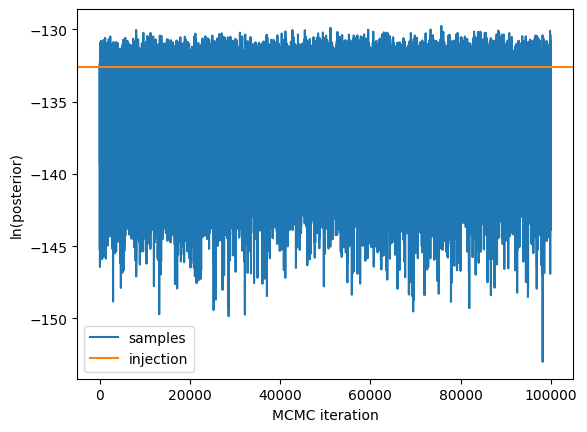

In [14]:
samples.plt_posterior_vals(legend=True)

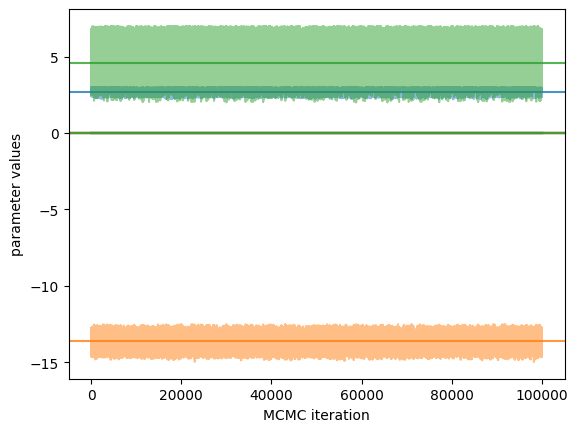

In [15]:
samples.trace_plt()

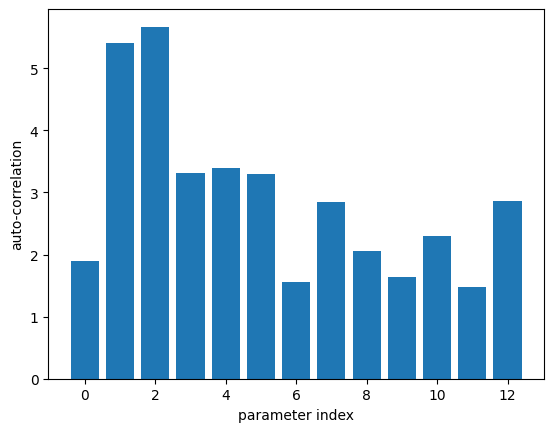

In [18]:
samples.plt_auto_corr()

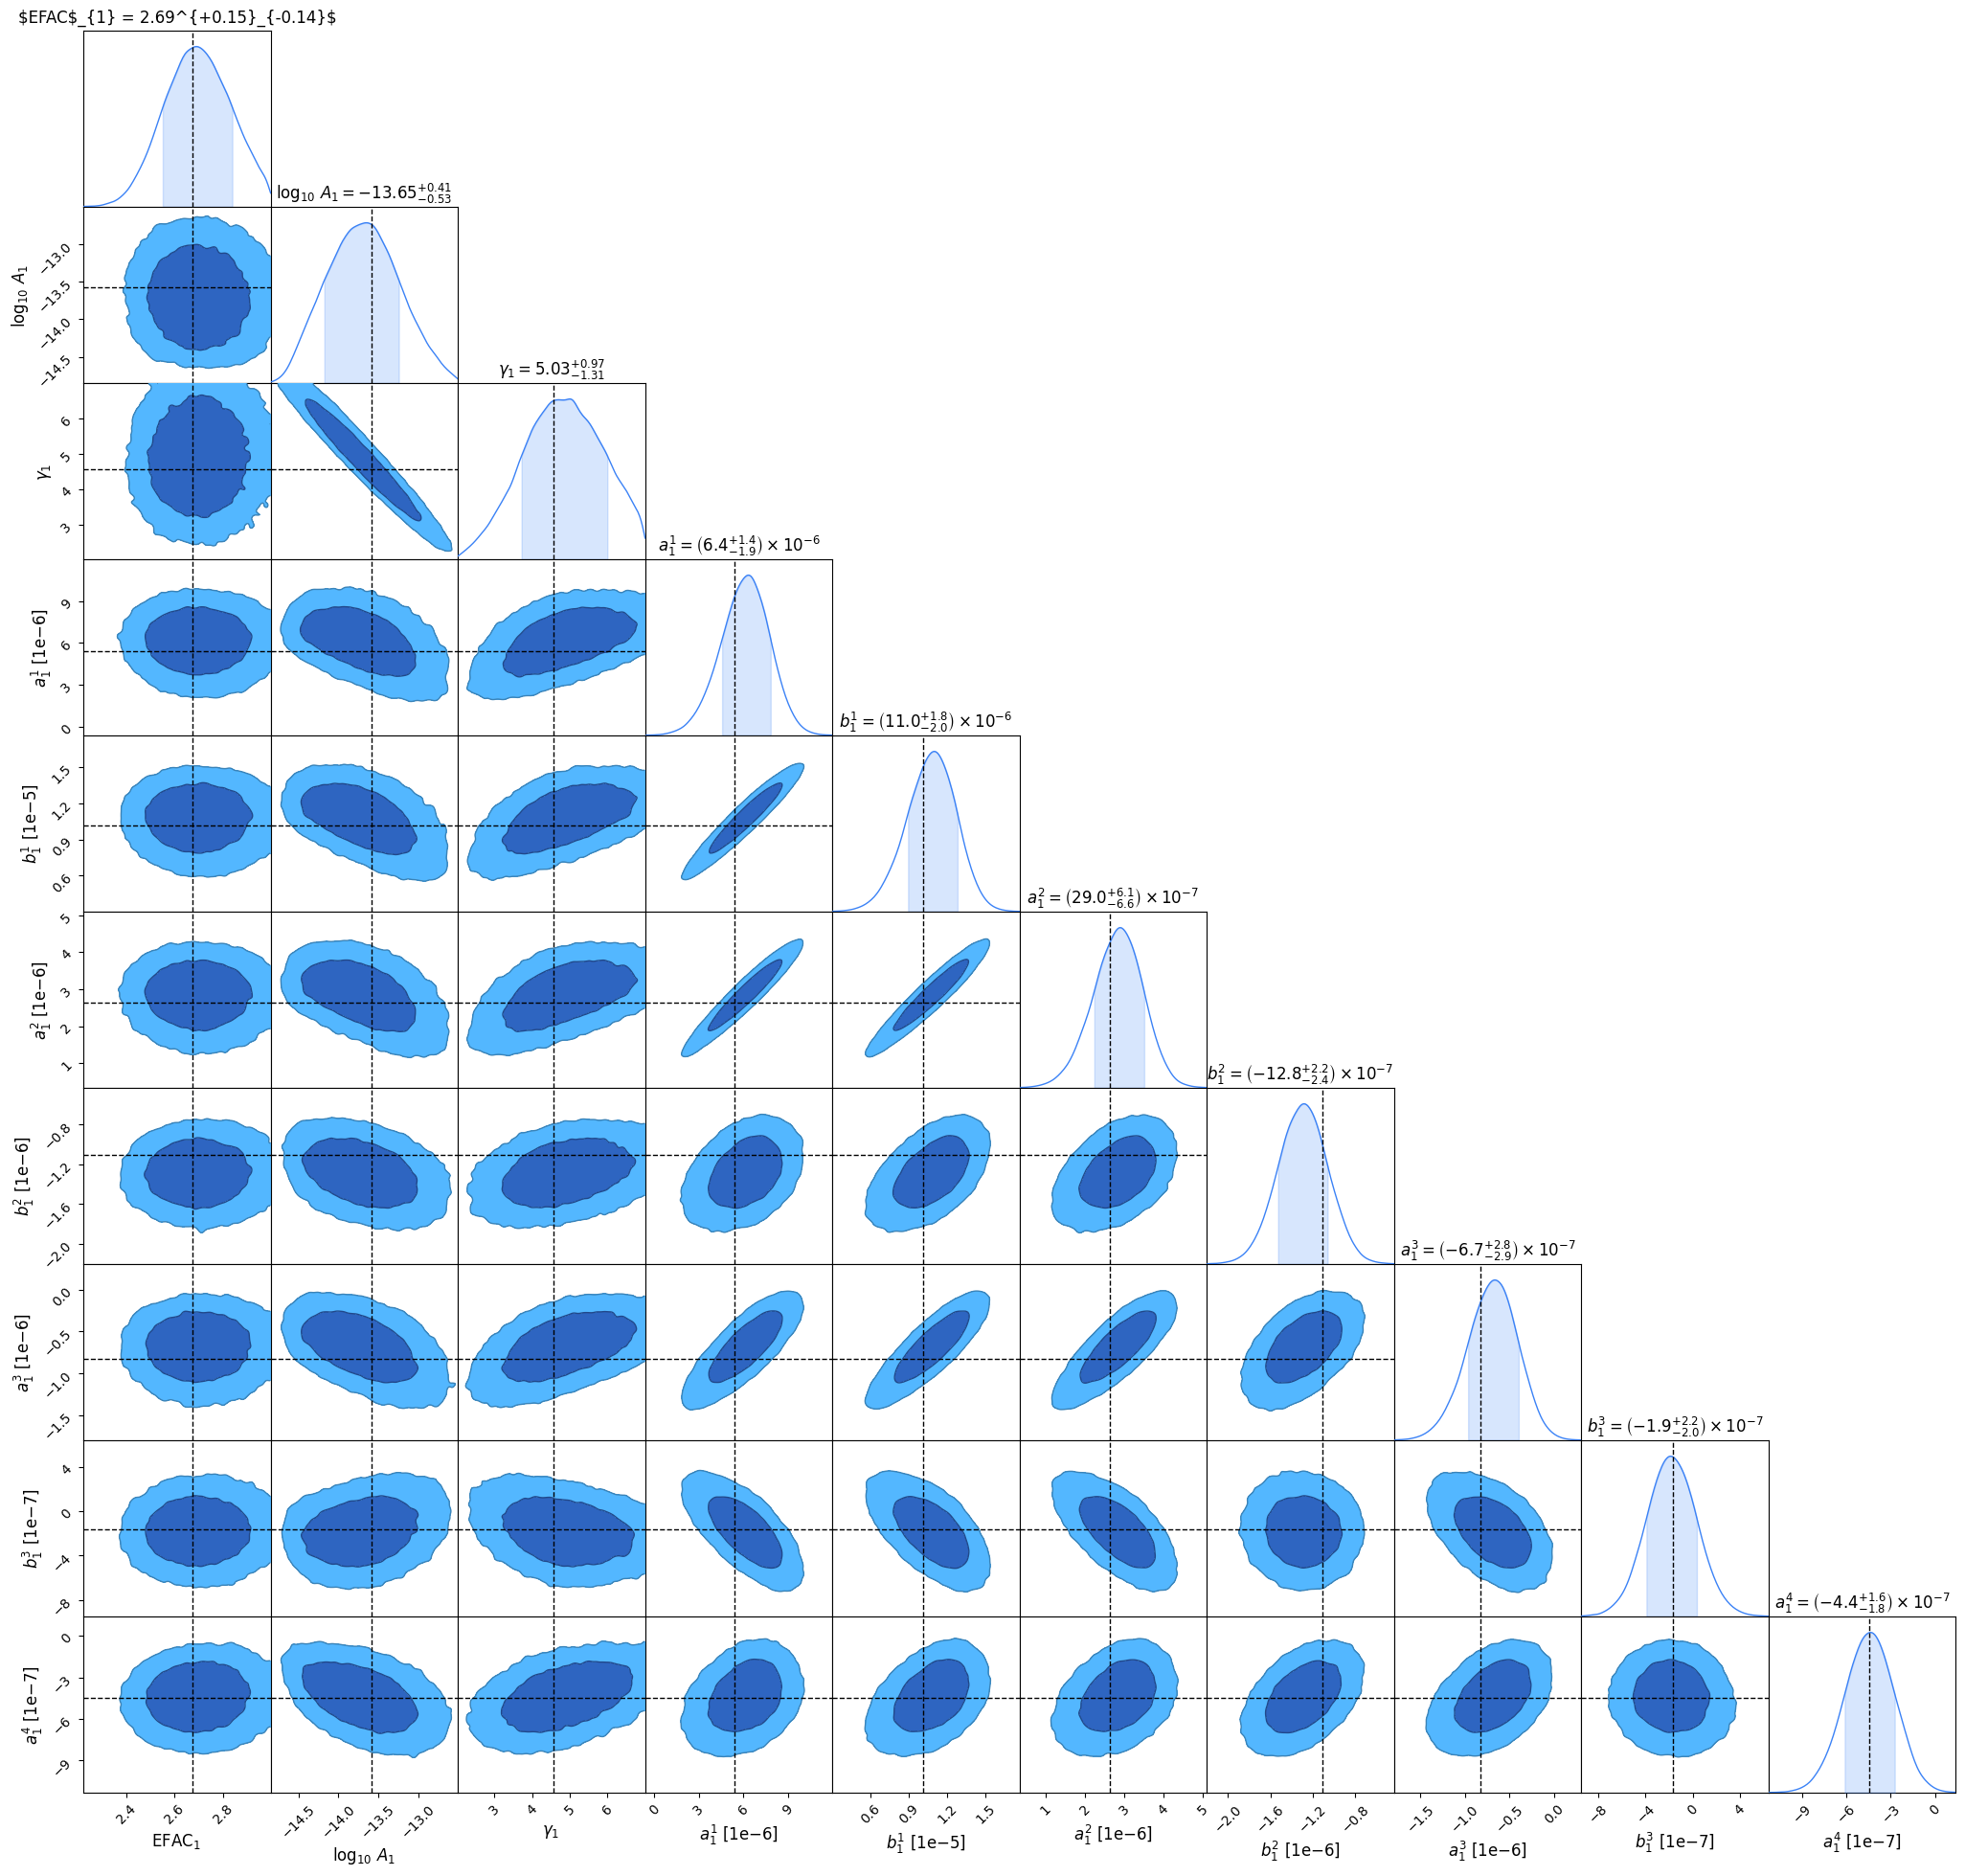

In [21]:
samples.corner_plt(np.r_[:10])

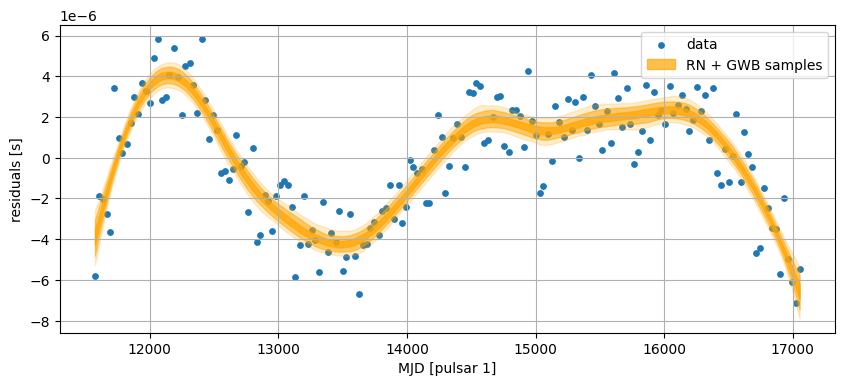

In [17]:
# Bayesogram
psr_ndx = 0
fair_draw_ndxs = np.random.choice(samples.shape[0], (1000,))

# percentile layers for plotting densities of samples
percentile_layers = [2.5, 10., 30.]
alphas = [0.2, 0.5, 0.7]

# plot data, samples, and injected signals
plt.figure(figsize=(10, 4))
plt.scatter(pta.MJDs[psr_ndx], pta.Rs[psr_ndx] @ pta.residuals[psr_ndx], color='C0', s=15, label='data')

# Bayesogram for RN + GWB
if pta.model_rn or pta.model_gwb:
    rn_gwb_signals = np.array([pta.Rs[psr_ndx] @ pta.Fs[psr_ndx] @ samples[ndx, pta.a_ndxs].reshape((pta.Np, pta.Na))[psr_ndx]
                           for ndx in fair_draw_ndxs])
    for percentile, alpha in zip(percentile_layers, alphas):
        if percentile != percentile_layers[-1]:
            plt.fill_between(pta.MJDs[psr_ndx], np.percentile(rn_gwb_signals, percentile, axis=0),
                            np.percentile(rn_gwb_signals, 100. - percentile, axis=0),
                            color='orange', alpha=alpha)
        else:
            plt.fill_between(pta.MJDs[psr_ndx], np.percentile(rn_gwb_signals, percentile, axis=0),
                            np.percentile(rn_gwb_signals, 100. - percentile, axis=0),
                            color='orange', alpha=alpha, label='RN + GWB samples')
    # rn_gwb_residuals_inj = pta.Rs[psr_ndx] @ pta.Fs[psr_ndx] @ pta.a_inj.reshape((pta.Np, pta.Na))[psr_ndx]

# Bayesogram for CW
if pta.model_cw:
    a_cws = np.array([pta.get_CW_coefficients(samples[ndx, pta.cw_psr_ndxs])[psr_ndx]
                  for ndx in fair_draw_ndxs])
    cw_signals = np.array([pta.Rs[psr_ndx] @ pta.Fs[psr_ndx] @ a_cw for a_cw in a_cws])
    for percentile, alpha in zip(percentile_layers, alphas):
        if percentile != percentile_layers[-1]:
            plt.fill_between(pta.MJDs[psr_ndx], np.percentile(cw_signals, percentile, axis=0),
                            np.percentile(cw_signals, 100. - percentile, axis=0),
                            color='green', alpha=alpha)
        else:
            plt.fill_between(pta.MJDs[psr_ndx], np.percentile(cw_signals, percentile, axis=0),
                            np.percentile(cw_signals, 100. - percentile, axis=0),
                            color='green', alpha=alpha, label='CW samples')
    # cw_residuals_inj = pta.Rs[psr_ndx] @ pta.Fs[psr_ndx] @ pta.get_CW_coefficients(pta.x_inj[pta.cw_psr_ndxs])[psr_ndx]

# Bayesogram for RN + GWB + CW
if pta.model_rn and pta.model_gwb and pta.model_cw:
    signals = cw_signals + rn_gwb_signals
    for percentile, alpha in zip(percentile_layers, alphas):
        if percentile != percentile_layers[-1]:
            plt.fill_between(pta.MJDs[psr_ndx], np.percentile(signals, percentile, axis=0),
                            np.percentile(signals, 100. - percentile, axis=0),
                            color='purple', alpha=alpha)
        else:
            plt.fill_between(pta.MJDs[psr_ndx], np.percentile(signals, percentile, axis=0),
                            np.percentile(signals, 100. - percentile, axis=0),
                            color='purple', alpha=alpha, label='RN + GWB + CW samples')
    # plt.plot(pta.MJDs[psr_ndx], rn_gwb_residuals_inj + cw_residuals_inj, color='C1', label='RN + GWB + CW injection')

plt.xlabel(f'MJD [pulsar {psr_ndx + 1}]')
plt.ylabel('residuals [s]')
plt.legend()
plt.grid()
plt.show()

In [18]:
np.save('hmc_samples1.npy', samples)